## Isolation forest

In [1]:
import copy
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import warnings
import glob
import os
from sklearn import preprocessing
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

warnings.filterwarnings('ignore')

In [2]:
complete_list = ['timestamp', 'lossOrNot']
selected_features_list_removing_correlation = [
    'interarrival_std',
    'interarrival_min',
    'interarrival_max',
    'interarrival_skew',
    'interarrival_moment4',
    'interarrival_max_min_R',
    'interarrival_max_value_count_percent',
    'len_udp_moment4',
    'len_udp_max_min_diff',
    'len_udp_max_value_count_percent',
    'inter_time_sequence_std'
]
complete_list.extend(selected_features_list_removing_correlation)

full_features_list = []
for feature in selected_features_list_removing_correlation:
    for i in range(1,11):
        col_title = f'{feature}_minus_{500*i}ms'
        full_features_list.append(col_title)

In [3]:
# load the entire dataset

df_complete_with_features_final = pd.read_csv('models/df_final_label_feature.csv')

In [4]:
df_complete_with_features_final

,timestamp,lossOrNot,group_id,interarrival_std_minus_500ms,interarrival_std_minus_1000ms,interarrival_std_minus_1500ms,interarrival_std_minus_2000ms,interarrival_std_minus_2500ms,interarrival_std_minus_3000ms,interarrival_std_minus_3500ms,...,inter_time_sequence_std_minus_500ms,inter_time_sequence_std_minus_1000ms,inter_time_sequence_std_minus_1500ms,inter_time_sequence_std_minus_2000ms,inter_time_sequence_std_minus_2500ms,inter_time_sequence_std_minus_3000ms,inter_time_sequence_std_minus_3500ms,inter_time_sequence_std_minus_4000ms,inter_time_sequence_std_minus_4500ms,inter_time_sequence_std_minus_5000ms
0,2020-12-14 13:34:44.500000,0.0,1,0.185914,0.111167,0.149341,0.168203,0.224819,0.287330,0.584144,...,0.362588,0.420006,0.202741,0.374366,0.419943,0.231871,0.164850,0.452376,0.182312,0.000000
1,2020-12-14 13:34:45,0.0,1,0.169699,0.185914,0.111167,0.149341,0.168203,0.224819,0.287330,...,0.204396,0.362588,0.420006,0.202741,0.374366,0.419943,0.231871,0.164850,0.452376,0.182312
2,2020-12-14 13:34:45.500000,0.0,1,0.122365,0.169699,0.185914,0.111167,0.149341,0.168203,0.224819,...,0.336296,0.204396,0.362588,0.420006,0.202741,0.374366,0.419943,0.231871,0.164850,0.452376
3,2020-12-14 13:34:46,0.0,1,0.081800,0.122365,0.169699,0.185914,0.111167,0.149341,0.168203,...,0.438010,0.336296,0.204396,0.362588,0.420006,0.202741,0.374366,0.419943,0.231871,0.164850
4,2020-12-14 13:34:46.500000,0.0,1,0.113890,0.081800,0.122365,0.169699,0.185914,0.111167,0.149341,...,0.210085,0.438010,0.336296,0.204396,0.362588,0.420006,0.202741,0.374366,0.419943,0.231871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2028655,2020-05-13 14:59:09.000,0.0,6998,0.083744,0.075046,0.078230,0.131936,0.078184,0.058745,0.069150,...,0.213018,1.000000,0.223662,0.202375,0.839116,0.213018,0.426054,0.213018,0.213018,0.934599
2028656,2020-05-13 14:59:09.500,0.0,6998,0.083497,0.083744,0.075046,0.078230,0.131936,0.078184,0.058745,...,0.213018,0.213018,1.000000,0.223662,0.202375,0.839116,0.213018,0.426054,0.213018,0.213018
2028657,2020-05-13 14:59:10.000,0.0,6998,0.048801,0.083497,0.083744,0.075046,0.078230,0.131936,0.078184,...,0.822931,0.213018,0.213018,1.000000,0.223662,0.202375,0.839116,0.213018,0.426054,0.213018
2028658,2020-05-13 14:59:10.500,0.0,6998,0.133611,0.048801,0.083497,0.083744,0.075046,0.078230,0.131936,...,0.223662,0.822931,0.213018,0.213018,1.000000,0.223662,0.202375,0.839116,0.213018,0.426054


In [5]:
df_loss = df_complete_with_features_final[df_complete_with_features_final['lossOrNot'] > 0]
df_no_loss = df_complete_with_features_final[df_complete_with_features_final['lossOrNot'] < 1]

df_loss_shuffled = df_loss.sample(frac=1).reset_index()
df_loss_shuffled.drop(['index'], axis=1, inplace=True)
df_no_loss_shuffled = df_no_loss.sample(frac=1).reset_index()
df_no_loss_shuffled.drop(['index'], axis=1, inplace=True)

In [6]:
df_train = pd.concat([df_loss_shuffled.iloc[0:int(df_loss_shuffled.shape[0] * 0.7)], df_no_loss_shuffled.iloc[0:int(df_no_loss_shuffled.shape[0] * 0.7)]])
df_train_shuffled = df_train.sample(frac=1).reset_index()
df_train_shuffled.drop(['index'], axis=1, inplace=True)
df_test = pd.concat([df_loss_shuffled.iloc[int(df_loss_shuffled.shape[0] * 0.7)+1: -1], df_no_loss_shuffled.iloc[int(df_no_loss_shuffled.shape[0] * 0.7)+1: -1]])
df_test_shuffled = df_test.sample(frac=1).reset_index()
df_test_shuffled.drop(['index'], axis=1, inplace=True)

In [7]:
x_train = df_train_shuffled[full_features_list]
x_test = df_test_shuffled[full_features_list]
y_train = df_train_shuffled[['lossOrNot']]
y_train = y_train.astype(int)
y_test = df_test_shuffled[['lossOrNot']]
y_test = y_test.astype(int)

In [10]:
contamination = y_train[y_train['lossOrNot']==1]['lossOrNot'].count() / len(y_train)
contamination

0.013903628083582325

In [14]:
if_model = IsolationForest(n_estimators=100, max_samples=0.25, random_state=1, contamination=contamination, n_jobs=48) # or n_estimators=200, max_samples=1.0

In [15]:
# training set

if_model.fit(x_train)

IsolationForest(contamination=0.014099664575949588, max_samples=1.0,
                n_estimators=200, n_jobs=48, random_state=1)

In [16]:
y_pred_train = if_model.predict(x_train)

In [17]:
y_pred_train_label = [0 if x==1 else 1 for x in y_pred_train]

Prediction Report
               precision    recall  f1-score   support

           0       0.99      0.99      0.99   1400317
           1       0.02      0.02      0.02     19744

    accuracy                           0.97   1420061
   macro avg       0.50      0.50      0.50   1420061
weighted avg       0.97      0.97      0.97   1420061



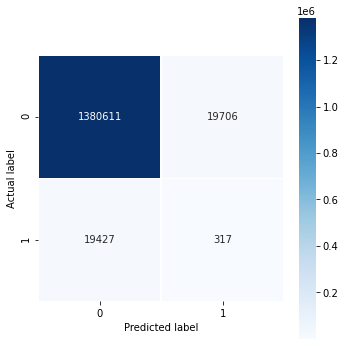

In [50]:
print("Prediction Report\n", classification_report(y_train, y_pred_train_label))
cm = confusion_matrix(y_train, y_pred_train_label)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [27]:
# y_pred_score_train = if_model.decision_function(x_train)

In [24]:
# test set

y_pred_test = if_model.predict(x_test)

In [25]:
y_pred_test_label = [0 if x==1 else 1 for x in y_pred_test]

Prediction Report
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    600134
           1       0.01      0.01      0.01      8461

    accuracy                           0.97    608595
   macro avg       0.50      0.50      0.50    608595
weighted avg       0.97      0.97      0.97    608595



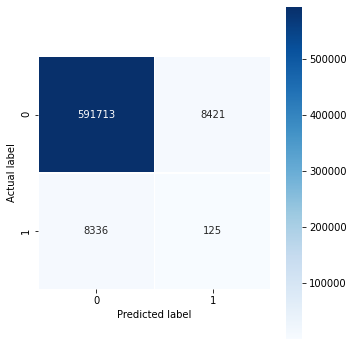

In [26]:
print("Prediction Report\n", classification_report(y_test, y_pred_test_label))
cm = confusion_matrix(y_test, y_pred_test_label)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

Prediction Report with features of past 500ms
               precision    recall  f1-score   support

           0       0.99      0.99      0.99   1400317
           1       0.02      0.02      0.02     19744

    accuracy                           0.97   1420061
   macro avg       0.50      0.50      0.50   1420061
weighted avg       0.97      0.97      0.97   1420061



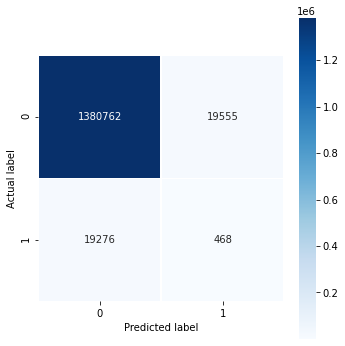

Prediction Report with features of past 1000ms
               precision    recall  f1-score   support

           0       0.99      0.99      0.99   1400317
           1       0.02      0.02      0.02     19744

    accuracy                           0.97   1420061
   macro avg       0.50      0.50      0.50   1420061
weighted avg       0.97      0.97      0.97   1420061



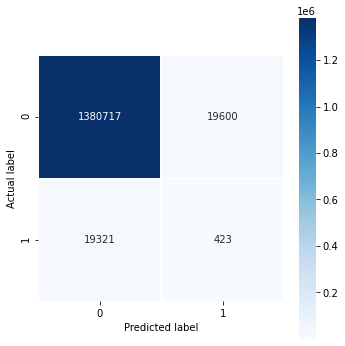

Prediction Report with features of past 1500ms
               precision    recall  f1-score   support

           0       0.99      0.99      0.99   1400317
           1       0.02      0.02      0.02     19744

    accuracy                           0.97   1420061
   macro avg       0.50      0.50      0.50   1420061
weighted avg       0.97      0.97      0.97   1420061



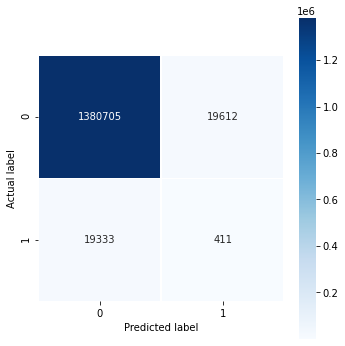

Prediction Report with features of past 2000ms
               precision    recall  f1-score   support

           0       0.99      0.99      0.99   1400317
           1       0.02      0.02      0.02     19744

    accuracy                           0.97   1420061
   macro avg       0.50      0.50      0.50   1420061
weighted avg       0.97      0.97      0.97   1420061



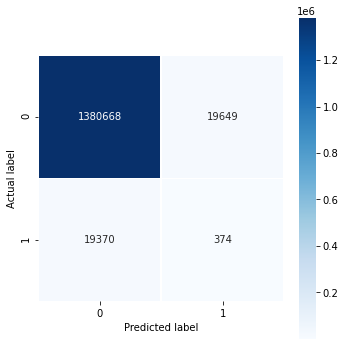

Prediction Report with features of past 2500ms
               precision    recall  f1-score   support

           0       0.99      0.99      0.99   1400317
           1       0.02      0.02      0.02     19744

    accuracy                           0.97   1420061
   macro avg       0.50      0.50      0.50   1420061
weighted avg       0.97      0.97      0.97   1420061



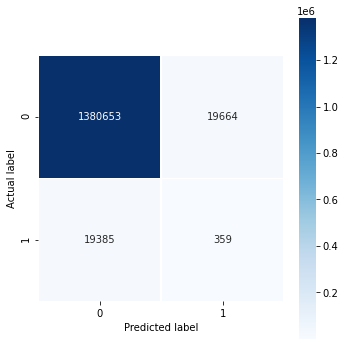

Prediction Report with features of past 3000ms
               precision    recall  f1-score   support

           0       0.99      0.99      0.99   1400317
           1       0.02      0.02      0.02     19744

    accuracy                           0.97   1420061
   macro avg       0.50      0.50      0.50   1420061
weighted avg       0.97      0.97      0.97   1420061



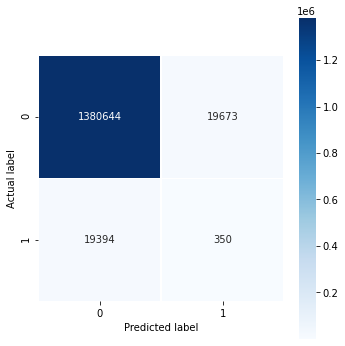

Prediction Report with features of past 3500ms
               precision    recall  f1-score   support

           0       0.99      0.99      0.99   1400317
           1       0.02      0.02      0.02     19744

    accuracy                           0.97   1420061
   macro avg       0.50      0.50      0.50   1420061
weighted avg       0.97      0.97      0.97   1420061



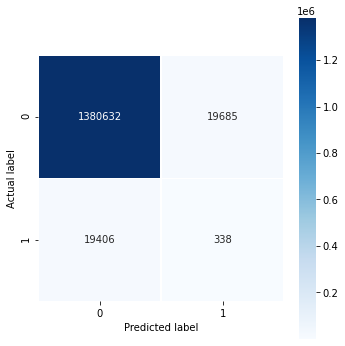

Prediction Report with features of past 4000ms
               precision    recall  f1-score   support

           0       0.99      0.99      0.99   1400317
           1       0.02      0.02      0.02     19744

    accuracy                           0.97   1420061
   macro avg       0.50      0.50      0.50   1420061
weighted avg       0.97      0.97      0.97   1420061



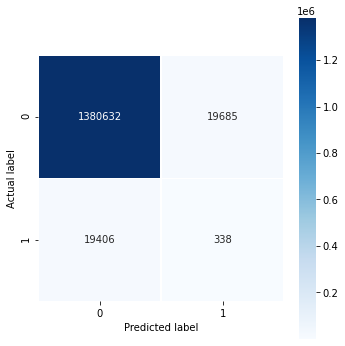

Prediction Report with features of past 4500ms
               precision    recall  f1-score   support

           0       0.99      0.99      0.99   1400317
           1       0.02      0.02      0.02     19744

    accuracy                           0.97   1420061
   macro avg       0.50      0.50      0.50   1420061
weighted avg       0.97      0.97      0.97   1420061



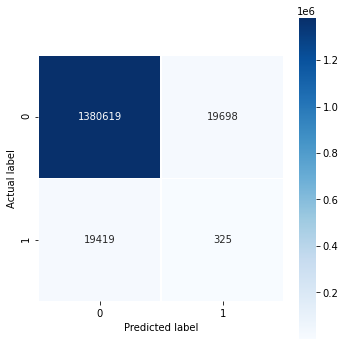

Prediction Report with features of past 5000ms
               precision    recall  f1-score   support

           0       0.99      0.99      0.99   1400317
           1       0.02      0.02      0.02     19744

    accuracy                           0.97   1420061
   macro avg       0.50      0.50      0.50   1420061
weighted avg       0.97      0.97      0.97   1420061



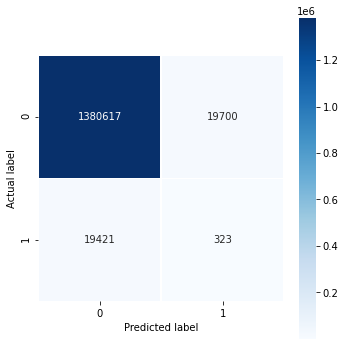

In [53]:
# select value starting from past 5 sec (10 samples) to 0.5 sec (1 sample)

acc = []
precision = []                                         
recall = []
f1 = []
label = [f'-{500*x}ms' for x in range(10, 0, -1)]

for num_feature in range(2,12):
    
    # build features
    shrink_feature_list = []
    for feature in selected_features_list_removing_correlation:
        for i in range(1, num_feature):
            col_title = f'{feature}_minus_{500*i}ms'
            shrink_feature_list.append(col_title)
            
    # build training and testing dataset
    x_train_new = df_train_shuffled[shrink_feature_list]
#     x_test_new = df_test_shuffled[shrink_feature_list]
    y_train_new = df_train_shuffled[['lossOrNot']]
    y_train_new = y_train_new.astype(int)
#     y_test_new = df_test_shuffled[['lossOrNot']]
#     y_test_new = y_test_new.astype(int)
    
    if_model_new = IsolationForest(n_estimators=100, max_samples=0.25, random_state=1, contamination=contamination, n_jobs=48)
    if_model_new.fit(x_train_new)
    
    # output result
    y_pred_train = if_model_new.predict(x_train_new)
    y_pred_train_label = [0 if x==1 else 1 for x in y_pred_train]
    print(f"Prediction Report with features of past {(num_feature-1)*500}ms\n", classification_report(y_train_new, y_pred_train_label))
    cm = confusion_matrix(y_train_new, y_pred_train_label)
    plt.figure(figsize=(5,5))
    sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
    # store the result, note that the order of values here is opposite with the label, need to reverse later
    report = classification_report(y_train_new, y_pred_train_label, output_dict=True)
    acc.append(report['accuracy'])
    precision.append(report['macro avg']['precision'])                                  
    recall.append(report['macro avg']['recall'])
    f1.append(report['macro avg']['f1-score'])

## Local outlier factor

In [14]:
# df_train = pd.concat([df_loss_shuffled.iloc[0:int(df_loss_shuffled.shape[0] * 0.05)], df_no_loss_shuffled.iloc[0:int(df_no_loss_shuffled.shape[0] * 0.05)]])
# df_train_shuffled = df_train.sample(frac=1).reset_index()
# df_train_shuffled.drop(['index'], axis=1, inplace=True)
# df_test = pd.concat([df_loss_shuffled.iloc[int(df_loss_shuffled.shape[0] * 0.05)+1: -1], df_no_loss_shuffled.iloc[int(df_no_loss_shuffled.shape[0] * 0.05)+1: -1]])
# df_test_shuffled = df_test.sample(frac=1).reset_index()
# df_test_shuffled.drop(['index'], axis=1, inplace=True)

In [15]:
# x_train = df_train_shuffled[full_features_list]
# x_test = df_test_shuffled[full_features_list]
# y_train = df_train_shuffled[['lossOrNot']]
# y_train = y_train.astype(int)
# y_test = df_test_shuffled[['lossOrNot']]
# y_test = y_test.astype(int)

In [17]:
# lof_model = LocalOutlierFactor(n_neighbors=20, contamination=contamination, n_jobs=48)

In [18]:
# y_pred_train = lof_model.fit_predict(x_train)

Prediction Report
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    100022
           1       0.03      0.03      0.03      1410

    accuracy                           0.97    101432
   macro avg       0.51      0.51      0.51    101432
weighted avg       0.97      0.97      0.97    101432



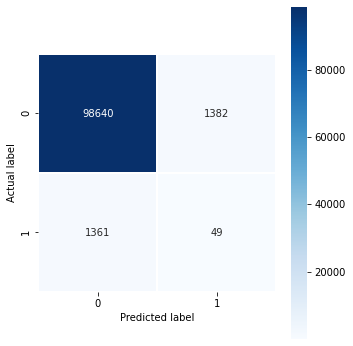

In [20]:
# y_pred_train_label = [0 if x==1 else 1 for x in y_pred_train]
# print("Prediction Report\n", classification_report(y_train, y_pred_train_label))
# cm = confusion_matrix(y_train, y_pred_train_label)
# plt.figure(figsize=(5,5))
# sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
# plt.ylabel('Actual label')
# plt.xlabel('Predicted label')
# plt.tight_layout()
# plt.show()

## One Class SVM

In [ ]:
# ocsvm_model = OneClassSVM()

In [ ]:
# y_pred_train = ocsvm_model.fit_predict(x_train)

In [ ]:
# y_pred_train_label = [0 if x==1 else 1 for x in y_pred_train]
# print("Prediction Report\n", classification_report(y_train, y_pred_train_label))
# cm = confusion_matrix(y_train, y_pred_train_label)
# plt.figure(figsize=(5,5))
# sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
# plt.ylabel('Actual label')
# plt.xlabel('Predicted label')
# plt.tight_layout()
# plt.show()

In [22]:
# # check whether it can follow the trends

# count_loss_in_next_five_sec = 0
# count_loss_not_in_next_five_sec = 0

# for key, df_per_group in df_complete_with_features_final.groupby('group_id'):
#     df_temp = copy.deepcopy(df_per_group)
#     df_temp.reset_index(inplace=True)
#     df_temp.drop(columns=['index', 'group_id'], inplace=True)
#     pred = if_model.predict(df_temp[full_features_list])
#     idx_pred_loss = np.where(pred == -1)
    
#     for idx in idx_pred_loss[0]:
#         if idx+10 > len(df_temp):
#             df_check = df_temp.iloc[idx: -1]
#         else:
#             df_check = df_temp.iloc[idx: idx+10]
#         if df_check[df_check['lossOrNot'] == 1]['lossOrNot'].count() > 0:
#             count_loss_in_next_five_sec += 1
#         else:
#             count_loss_not_in_next_five_sec += 1

In [23]:
# print('"in its next 5s" includes itself, which means it is actually next 4.5s.')
# print('Number of predicted losses with at least one actual loss in its next 5s:', count_loss_in_next_five_sec)
# print('Number of predicted losses without any actual loss in its next 5s:', count_loss_not_in_next_five_sec)
# print('Probability of a predicted loss having at least one actual loss in its next 5s:', count_loss_in_next_five_sec / (count_loss_in_next_five_sec + count_loss_not_in_next_five_sec))

"in its next 5s" includes itself, which means it is actually next 4.5s.
Number of predicted losses with at least one actual loss in its next 5s: 1639
Number of predicted losses without any actual loss in its next 5s: 27318
Probability of a predicted loss having at least one actual loss in its next 5s: 0.056601167247988395
